In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from data_loaders import generate_shift_one_dim_dataset, sample_y_conditional_shift_one_dim
from loss import squared_loss
import numpy as np
from matplotlib.lines import Line2D 
from matplotlib.patches import Patch

In [9]:
X_train, y_train= generate_shift_one_dim_dataset(n=750, p=0.2, seed=0)

In [10]:
standard_erm_df = pd.read_csv("results/inference_shifted_one_dim_erm_1_squared_loss_p_train_0.2_seed_0.csv")
oracle_erm_df = pd.read_csv("results/inference_shifted_one_dim_erm_1_squared_loss_p_train_0.5_seed_0.csv")
ru_gamma_16 = pd.read_csv("results/inference_shifted_one_dim_ru_regression_16.0_squared_loss_p_train_0.2_seed_0.csv")
ru_gamma_8 = pd.read_csv("results/inference_shifted_one_dim_ru_regression_8.0_squared_loss_p_train_0.2_seed_0.csv")
ru_gamma_4 = pd.read_csv("results/inference_shifted_one_dim_ru_regression_4.0_squared_loss_p_train_0.2_seed_0.csv")
ru_gamma_2 = pd.read_csv("results/inference_shifted_one_dim_ru_regression_2.0_squared_loss_p_train_0.2_seed_0.csv")

In [11]:
def get_eta(gamma):
    return (gamma-1)/(gamma - 1/gamma)

def true_alpha(x, h_x, gamma):
    eta = get_eta(gamma)
    ys = sample_y_conditional_shift_one_dim(n=10000, p=0.2, x=x, seed=0)
    losses = squared_loss(ys, np.ones(ys.shape) * h_x)
    true_alpha = np.quantile(losses, eta)
    return true_alpha

In [13]:
def get_true_alpha(gamma):
    df = pd.read_csv("results/inference_shifted_one_dim_ru_regression_{}_squared_loss_p_train_0.2_seed_0.csv".format(float(gamma)))
    true_alphas = []
    for i, x in enumerate(df["X"]):
        true_alphas.append(true_alpha(x, df["y"][i], gamma))
    return true_alphas
                     

In [14]:
true_alphas_2 = get_true_alpha(2)
true_alphas_4 = get_true_alpha(4)
true_alphas_8 = get_true_alpha(8)
true_alphas_16 = get_true_alpha(16)

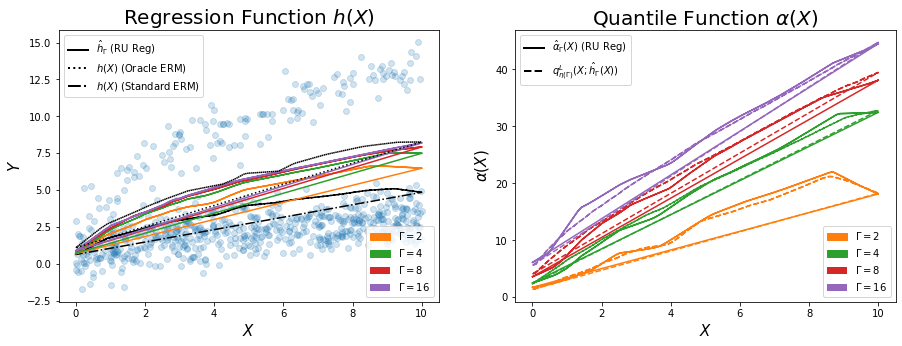

In [15]:
fig, ax =plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(X_train.flatten(), y_train, alpha=0.2)
dfs = [standard_erm_df, ru_gamma_2, ru_gamma_4, ru_gamma_8, ru_gamma_16, oracle_erm_df]
true_alphas = [None, true_alphas_2, true_alphas_4, true_alphas_8, true_alphas_16, None]
names = ["Standard ERM",
         r"$\hat{h}_{\Gamma}(X), \Gamma=2$",
         r"$\hat{h}_{\Gamma}(X), \Gamma=4$",
         r"$\hat{h}_{\Gamma}(X), \Gamma=8$",
         r"$\hat{h}_{\Gamma}(X), \Gamma=16$",
         "Oracle ERM",
        ]
alpha_names = [None,
         "$q_{\eta(\Gamma)}^{\$",
         "$q_{4}$",
         "$q_{8}$",
         "$q_{16}$",
         None]

est_alpha_names = [None, r"$\hat{\alpha}_{2}$",
                   r"$\hat{\alpha}_{4}$",
                   r"$\hat{\alpha}_{8}$",
                   r"$\hat{\alpha}_{16}$",
                  None]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

for i, df in enumerate(dfs):
    if i == 0:
        ax[0].plot(df["X"].to_numpy().flatten(), df["y"].to_numpy().flatten(), linestyle='dashdot', color="black")
    elif i == len(dfs)-1:
        ax[0].plot(df["X"].to_numpy().flatten(), df["y"].to_numpy().flatten(), linestyle='dotted', color="black")
    else:
        ax[0].plot(df["X"].to_numpy().flatten(), df["y"].to_numpy().flatten(), color=colors[i])
    if i in list(range(1, len(dfs)-1)):
        ax[1].plot(df["X"].to_numpy().flatten(), df["alpha"].to_numpy().flatten(), c=colors[i])
        ax[1].plot(df["X"].to_numpy().flatten(), true_alphas[i], c=colors[i], linestyle='--')

ax[0].set_ylabel(r"$Y$",fontsize=15)
ax[1].set_ylabel(r"$\alpha(X)$",fontsize=15)

custom_lines1 = [Line2D([0], [0], lw=2, label=r"$\hat{\alpha}_{\Gamma}(X)$" + " (RU Reg)", color="black"), 
                Line2D([0], [0], linestyle="--", lw=2, label=r"$q_{\eta(\Gamma)}^{L}(X; \hat{h}_{\Gamma}(X))$", color="black")]

custom_lines0= [Line2D([0], [0], lw=2, label=r"$\hat{h}_{\Gamma}$" + " (RU Reg)", color="black"),
                Line2D([0], [0], linestyle="dotted", lw=2, label=r"$h(X)$" + " (Oracle ERM)", color="black"),
                Line2D([0], [0], linestyle="dashdot", lw=2, label=r"$h(X)$" + " (Standard ERM)", color="black")]



custom_colors = [Patch(color='tab:orange', label=r'$\Gamma=2$'), 
                Patch(color='tab:green', label=r'$\Gamma=4$'), 
                Patch(facecolor='tab:red', label=r'$\Gamma=8$'),
                Patch(facecolor='tab:purple', label=r'$\Gamma=16$')]

leg0 =  ax[0].legend(handles=custom_colors, loc="lower right")
leg1 =  ax[1].legend(handles=custom_colors, loc="lower right")
ax[0].add_artist(leg0)
ax[1].add_artist(leg1)

for i in range(2):
    ax[i].set_xlabel(r"$X$",fontsize=15)

ax[1].legend(handles=custom_lines1, loc="upper left")
ax[0].legend(handles=custom_lines0, loc="upper left")

ax[0].set_title("Regression Function " + r"$h(X)$", fontsize=20)
ax[1].set_title("Quantile Function " + r"$\alpha(X)$",fontsize=20)
plt.savefig("figs/learned_regression.pdf")